# Section A: Convolutinal Nueral Network

Name: Joen Choo Tze En<br>
Admin Number: P2415828<br>
Class: DAAA/FT/2B/22<br>

## Project Objective
Implement an image classifier using a deep learning network, to classify images into 11 classes of vegetables.<br/>
We will build two models for two different input sizes (23x23 and 101x101)<br/>
We want to compare the two classification models and their results

---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import random
import cv2
import os

from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.utils import to_categorical

# Set the random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

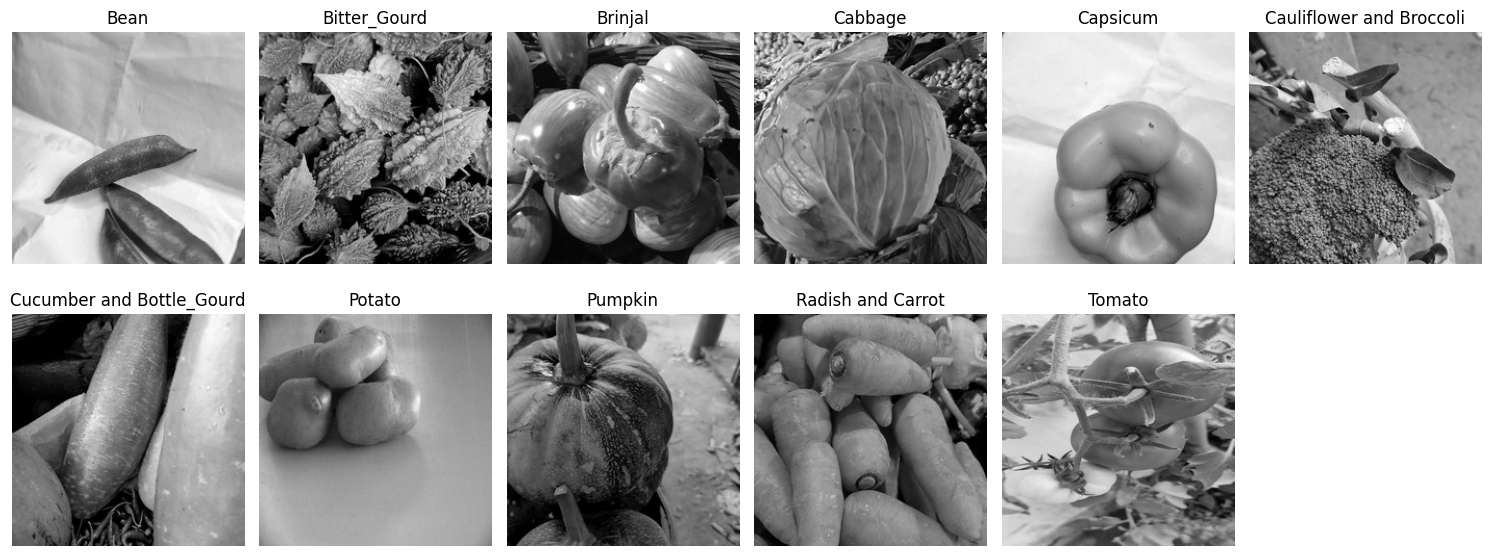

In [3]:
def show_images(folder_path):
    class_names = sorted(os.listdir(folder_path))
    plt.figure(figsize=(15, 6))
    for i, cls in enumerate(class_names):
        class_dir = os.path.join(folder_path, cls)
        img_name = os.listdir(class_dir)[random.randint(0,9)]
        img = cv2.imread(os.path.join(class_dir, img_name), cv2.IMREAD_GRAYSCALE)
        plt.subplot(2, len(class_names)//2 + 1, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(cls)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images('Datasets/train')

# | Preprocess Data

From observation, there are many mistakes within the dataset (images in wrong class, incorrect class labels)
I had to remove images/rename file names.

In [4]:
import os

# Paths to dataset folders
base_path = 'Datasets'
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'validation')
test_path = os.path.join(base_path, 'test')

image_size_small = (23, 23)
image_size_large = (101, 101)

def convert_to_grayscale(image, label):
    if tf.shape(image)[-1] == 3:
        image = tf.image.rgb_to_grayscale(image)
    return image, label

train_data_23 = image_dataset_from_directory(train_path, labels='inferred', image_size=image_size_small, color_mode='grayscale')
val_data_23 = image_dataset_from_directory(val_path, labels='inferred', image_size=image_size_small, color_mode='grayscale')
test_data_23 = image_dataset_from_directory(test_path, labels='inferred', image_size=image_size_small, color_mode='grayscale')

train_data_101 = image_dataset_from_directory(train_path, labels='inferred', image_size=image_size_large, color_mode='grayscale')
val_data_101 = image_dataset_from_directory(val_path, labels='inferred', image_size=image_size_large, color_mode='grayscale')
test_data_101 = image_dataset_from_directory(test_path, labels='inferred', image_size=image_size_large, color_mode='grayscale')

Found 7695 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 7695 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.


In [5]:
def seperate_dataset_object(dataset):
    X, y = [], []
    for image, label in dataset:
        X.append(image)
        y.append(label)
    X = tf.concat(X, axis=0).numpy()
    y = tf.concat(y, axis=0).numpy()
    return X, y

X_train_23, y_train_23 = seperate_dataset_object(train_data_23)
X_val_23, y_val_23 = seperate_dataset_object(val_data_23)
X_test_23, y_test_23 = seperate_dataset_object(test_data_23)

X_train_101, y_train_101 = seperate_dataset_object(train_data_101)
X_val_101, y_val_101 = seperate_dataset_object(val_data_101)
X_test_101, y_test_101 = seperate_dataset_object(test_data_101)

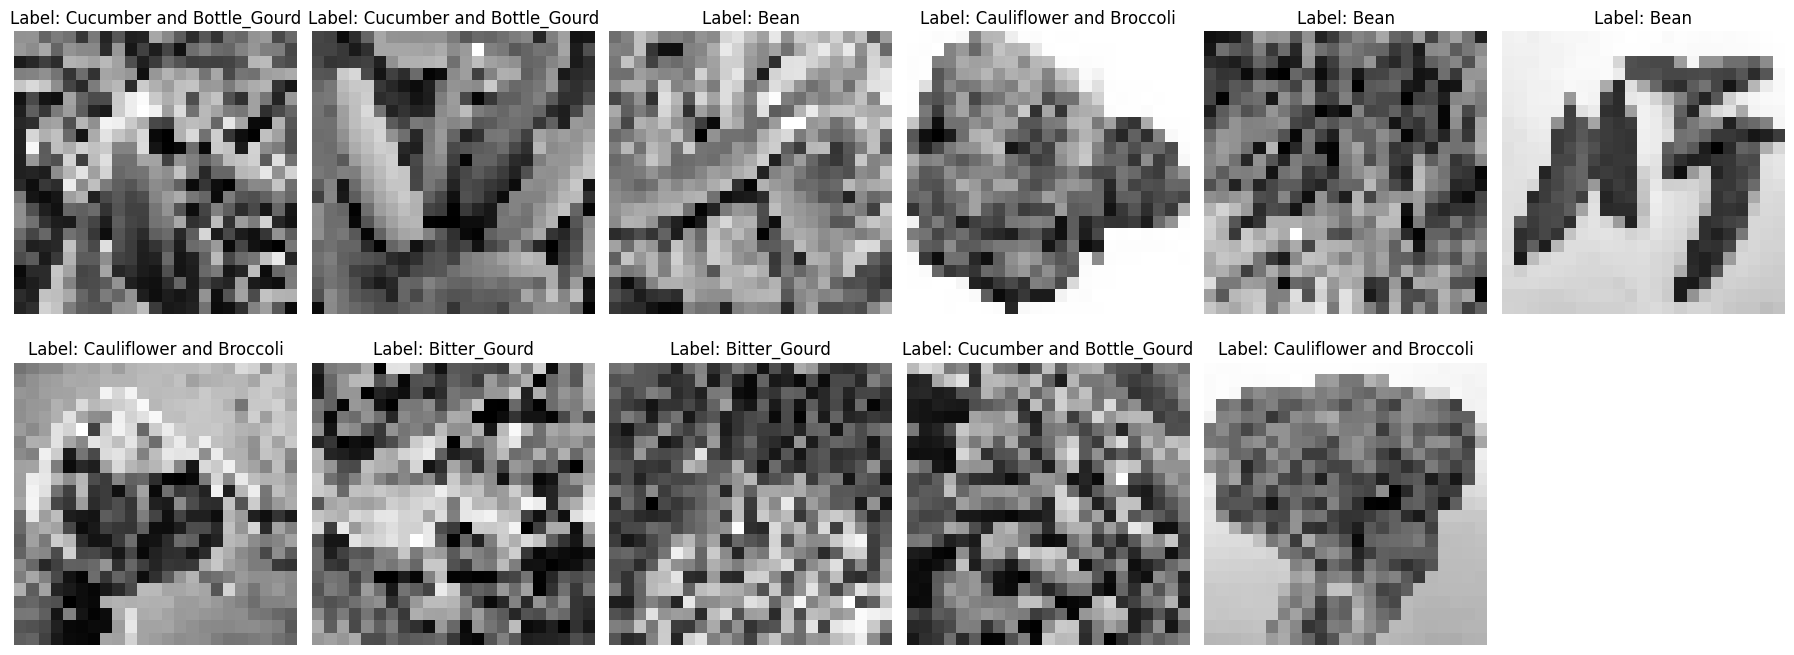

In [9]:
def show_sample_images(X, y, class_names):
    plt.figure(figsize=(18, 7))
    indices = random.sample(range(len(X)), len(class_names))
    
    for i, idx in enumerate(indices):
        plt.subplot(2, len(class_names)//2 + 1, i+1)
        plt.imshow(X[idx].squeeze(), cmap='gray')
        plt.title(f"Label: {class_names[y[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

class_names = sorted(os.listdir(train_path))
show_sample_images(X_train_23, y_train_23, class_names)

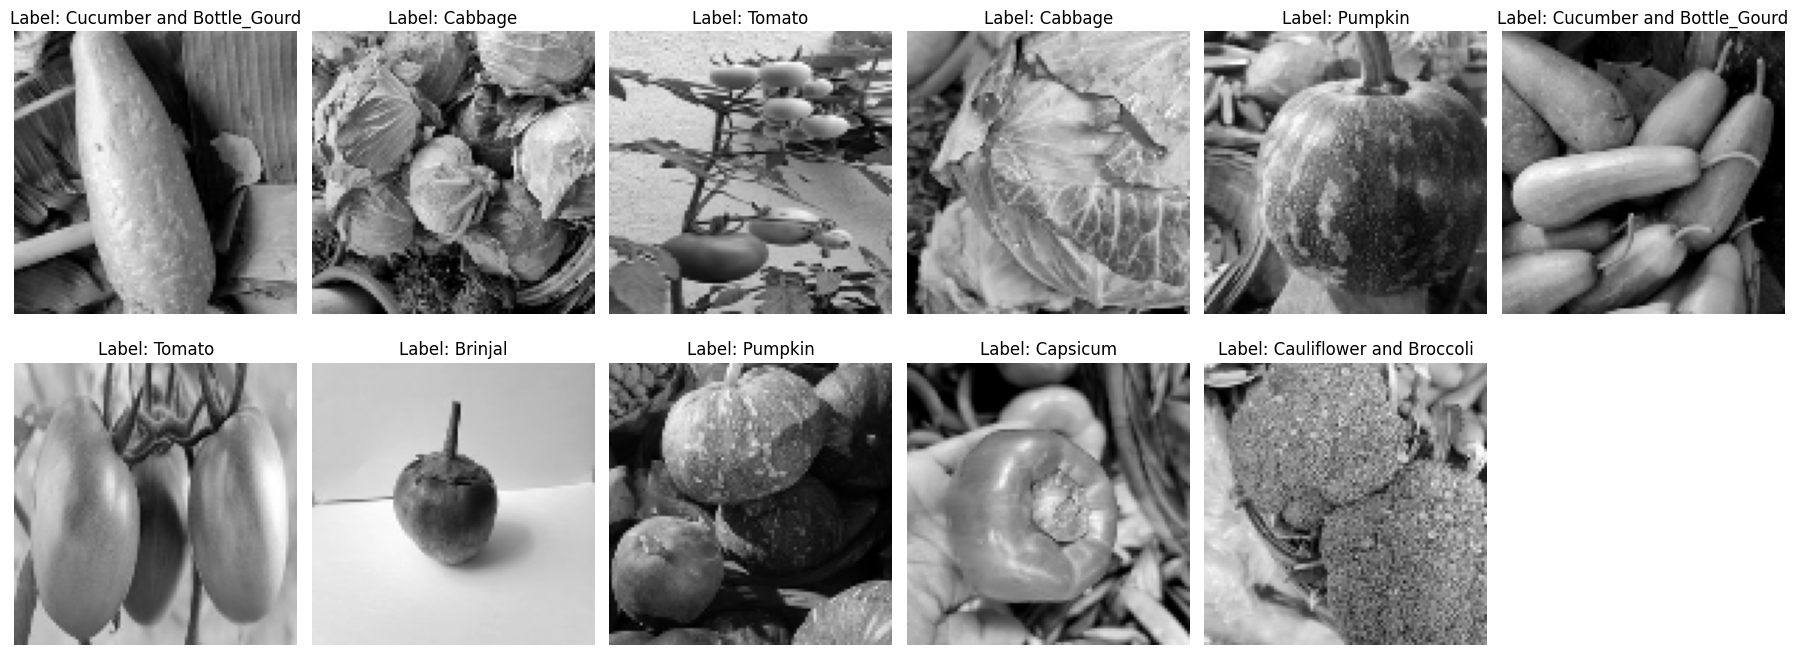

In [23]:
show_sample_images(X_train_101, y_train_101, class_names)

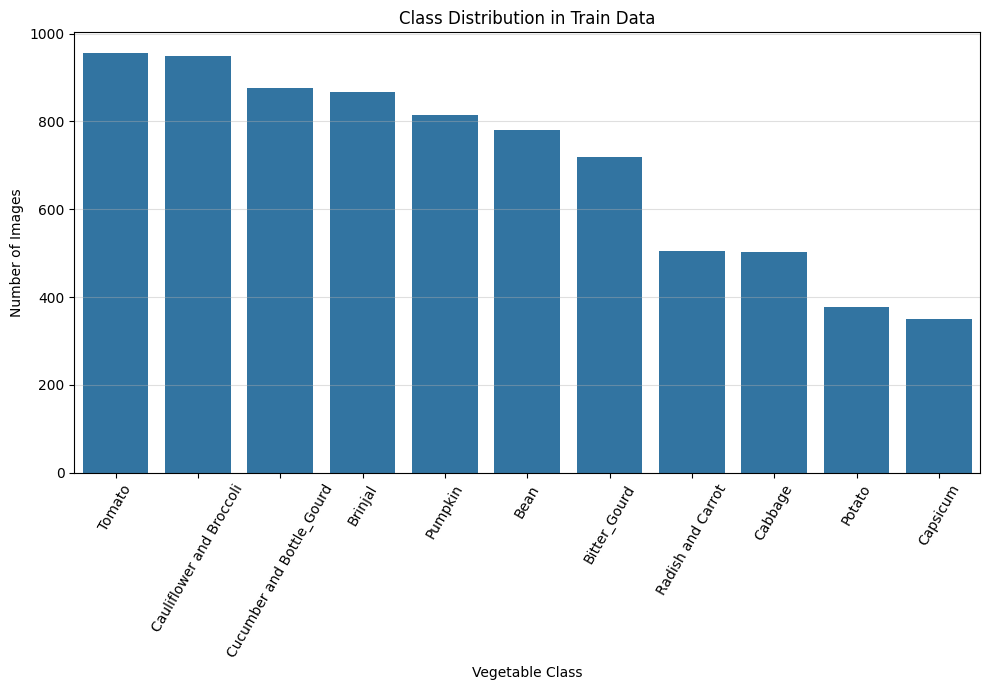

In [10]:
label_names = [class_names[idx] for idx in y_train_23]

# Create a DataFrame
df = pd.DataFrame({'Class': label_names})

# Count and plot
plt.figure(figsize=(10, 7))
sns.barplot(x=df['Class'].value_counts().index, y=df['Class'].value_counts().values)
plt.xticks(rotation=60)
plt.xlabel("Vegetable Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Train Data")
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()

There is imbalance of data in the train dataset
- To solve this we will use class weights as an easy method to balance the data

In [11]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(y_train_23)),y=np.array(y_train_23))
# Convert to Series
class_weight_dict = pd.Series(class_weights, index=class_names)
print(f"Class weights: \n\n{class_weight_dict}")
class_weight_dict = dict(enumerate(class_weights))

Class weights: 

Bean                         0.896853
Bitter_Gourd                 0.971591
Brinjal                      0.805928
Cabbage                      1.390746
Capsicum                     1.993007
Cauliflower and Broccoli     0.737917
Cucumber and Bottle_Gourd    0.799481
Potato                       1.855558
Pumpkin                      0.859392
Radish and Carrot            1.387987
Tomato                       0.732508
dtype: float64


### Normalization
We apply normalization to the features as:
- The model expects values from 0 to 255
- Models train faster and more stably when inputs are on a consistent scale. (faster convergence)
- Prevents certain features (e.g., brighter pixels) from dominating.

In [12]:
# I will normalize input data by adding a Rescalling() layer into our models
from keras.layers import Rescaling
# Rescaling(1.0/255, input_shape=(23, 23, 1))

# | 23x23 Model

## Model training

In [13]:
# One-hot encode the labels
num_classes = len(class_names)
y_train_23_cat = to_categorical(y_train_23, num_classes)
y_val_23_cat = to_categorical(y_val_23, num_classes)
y_test_23_cat = to_categorical(y_test_23, num_classes)

In [14]:
# Define a function for plotting learning curves
def plot_learning_curve(history):
    fig, ax = plt.subplots(1,2, figsize=(14,6))
    
    # Training loss and validation loss
    ax1=ax[0]
    ax1.plot(history.history["loss"], label="Training Loss")
    ax1.plot(history.history["val_loss"], label="Validation Loss")
    ax1.legend()
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Number of Epochs")
    ax1.set_title("Training and Validation Loss")

    # Training accuracy and validation accuracy
    ax2=ax[1]
    ax2.plot(history.history["accuracy"], label="Training Accuracy")
    ax2.plot(history.history["val_accuracy"], label="Validation Accuracy")
    ax2.legend()
    ax2.set_ylabel("Accuracy")
    ax2.set_xlabel("Number of Epochs")
    ax2.set_title("Training and Validation Accuracy")
    plt.show()

In [ ]:
# Define the model
baseline_23 = Sequential(name="baseline_23", layers = [
    Rescaling(1.0/255, input_shape=(23, 23, 1)), # Normalize data
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile model
baseline_23.compile(
    optimizer=Adam(), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Model summary
baseline_23.summary()

Model: "baseline_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 23, 23, 1)         0         
                                                                 
 conv2d_64 (Conv2D)          (None, 21, 21, 32)        320       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 10, 10, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 4, 4, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 2, 2, 128)         

In [ ]:
history = baseline_23.fit(
    X_train_23, y_train_23_cat,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_23, y_val_23_cat),
    class_weight=class_weight_dict
)

Epoch 1/100
241/241 [==============================] - 2s 7ms/step - loss: 2.3323 - accuracy: 0.1415 - val_loss: 2.1870 - val_accuracy: 0.2736
Epoch 2/100
241/241 [==============================] - 1s 5ms/step - loss: 2.1215 - accuracy: 0.2472 - val_loss: 1.9295 - val_accuracy: 0.3391
Epoch 3/100
241/241 [==============================] - 1s 5ms/step - loss: 1.9388 - accuracy: 0.3220 - val_loss: 1.7833 - val_accuracy: 0.4141
Epoch 4/100
241/241 [==============================] - 1s 5ms/step - loss: 1.8241 - accuracy: 0.3604 - val_loss: 1.7018 - val_accuracy: 0.4282
Epoch 5/100
241/241 [==============================] - 1s 5ms/step - loss: 1.7049 - accuracy: 0.4173 - val_loss: 1.5309 - val_accuracy: 0.4895
Epoch 6/100
241/241 [==============================] - 1s 5ms/step - loss: 1.5735 - accuracy: 0.4573 - val_loss: 1.3849 - val_accuracy: 0.5486
Epoch 7/100
241/241 [==============================] - 1s 5ms/step - loss: 1.4812 - accuracy: 0.4942 - val_loss: 1.4361 - val_accuracy: 0.5145

In [ ]:
test_loss, test_acc = baseline_23.evaluate(X_test_23, y_test_23_cat)
print(f"Test accuracy: {test_acc:.2f}")

69/69 [==============================] - 0s 3ms/step - loss: 1.6254 - accuracy: 0.7632
Test accuracy: 0.76


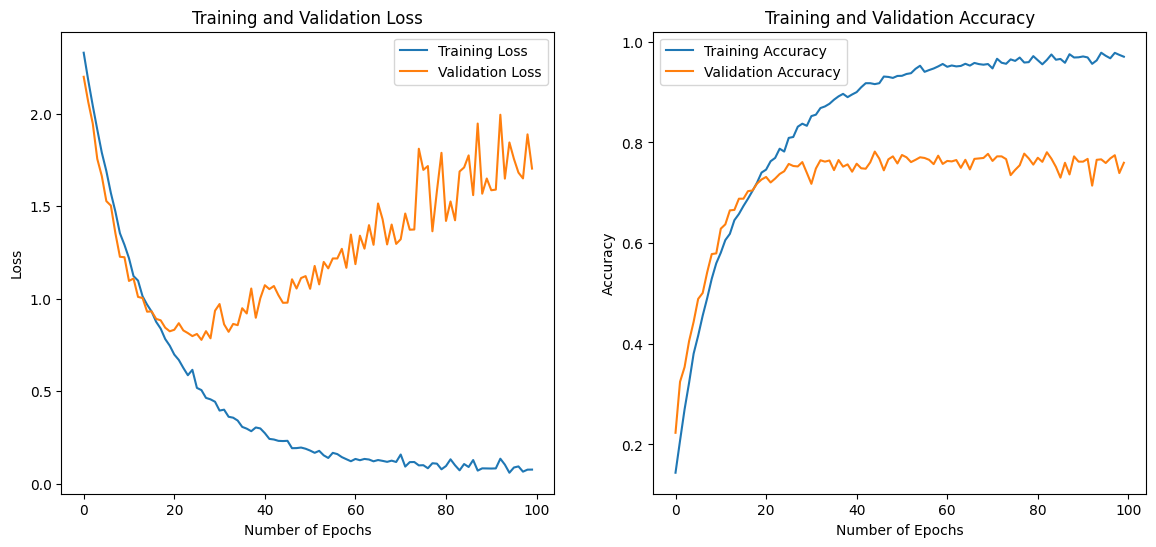

In [24]:
plot_learning_curve(history)

val loss increases after 20 epochs while train loss improves, val and test accuary is low.
- The model shows signs of overfitting

In [25]:
# callbacks = [
#     EarlyStopping(
#         monitor = "val_loss",
#         min_delta=1e-2,
#         patience=10,
#         verbose=1
#     )
# ]

I tried to implemet EarlyStopping, however the model would get stuck and not improve. Could be due to the way Early Stopping makes the model focus too much on one metric.

## Model Improvement

### Data Augmentation
We implement Data Augmentation as it:
- Increases dataset diversity
- Helps with limited training data
- Reduce overfitting

I choose to use Online Augmentation, which applies augmentations during training, creating a different version of each image at each epoch.<br/>
As it is efficient during training and easy to implement

In [56]:
# ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

aug_iter_train = datagen.flow(x=X_train_23, y=y_train_23, batch_size=200)

for i in range(25):
    image, label=next(aug_iter_train)
    aug_X_train_23 = np.append(aug_X_train_23, image, axis=0)
    aug_y_train_23 = np.append(aug_y_train_23, label)

print("Original shape: ", X_train_23.shape, y_train_23.shape)
print("Augmented shape: ", aug_X_train_23.shape, aug_y_train_23.shape)

aug_X_train_23 = np.append(X_train_23, aug_X_train_23, axis=0)
aug_y_train_23 = np.append(y_train_23, aug_y_train_23)
print("New shape: ", aug_X_train_23.shape, aug_y_train_23.shape)

aug_y_train_23_cat = to_categorical(aug_y_train_23, num_classes)

Original shape:  (7695, 23, 23, 1) (7695,)
Augmented shape:  (40180, 23, 23, 1) (40180,)
New shape:  (47875, 23, 23, 1) (47875,)


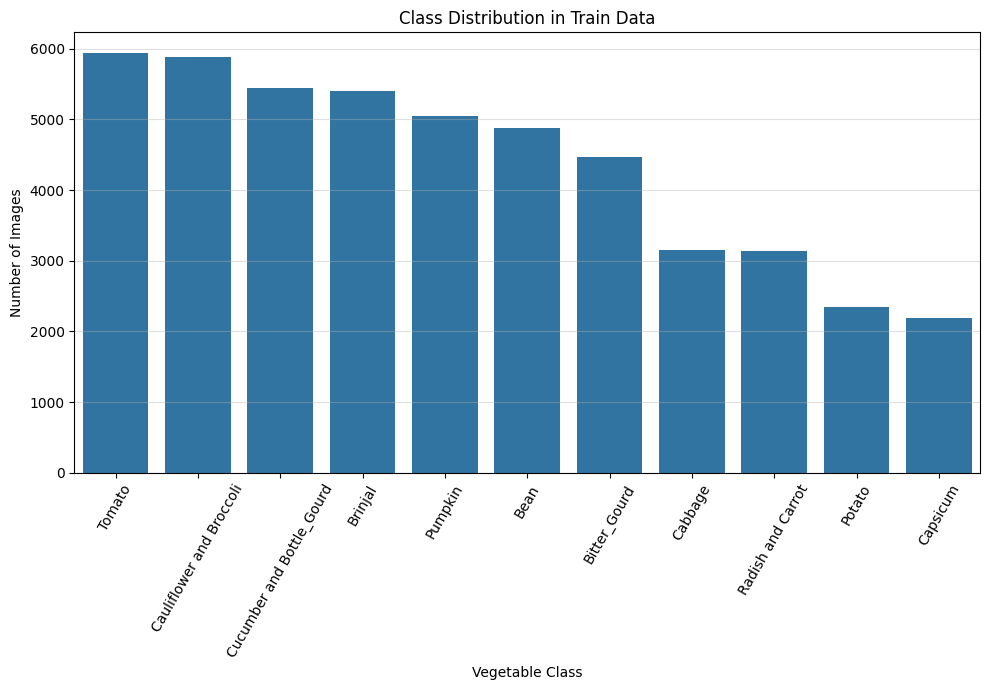

In [57]:
label_names = [class_names[idx] for idx in aug_y_train_23]

# Create a DataFrame
df = pd.DataFrame({'Class': label_names})

# Count and plot
plt.figure(figsize=(10, 7))
sns.barplot(x=df['Class'].value_counts().index, y=df['Class'].value_counts().values)
plt.xticks(rotation=60)
plt.xlabel("Vegetable Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Train Data")
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()

In [59]:
# Define the model
aug_23 = Sequential(name="nrmlzd_aug_23", layers = [
    Conv2D(32, (3, 3), activation='relu', input_shape=(23, 23, 1)),
    Rescaling(1.0/255), # Normalize data
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile model
aug_23.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
aug_23.summary()

Model: "nrmlzd_aug_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 21, 21, 32)        320       
                                                                 
 rescaling_16 (Rescaling)    (None, 21, 21, 32)        0         
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 10, 10, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_55 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 4, 4, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 2, 2, 128)       

In [ ]:
history = aug_23.fit(
    aug_X_train_23, aug_y_train_23_cat, 
    batch_size=32,
    epochs=100,
    validation_data=(X_val_23, y_val_23_cat),
    class_weight=class_weight_dict
)

Epoch 1/150
1497/1497 [==============================] - 7s 4ms/step - loss: 2.1104 - accuracy: 0.2461 - val_loss: 1.6995 - val_accuracy: 0.4182
Epoch 2/150
1497/1497 [==============================] - 7s 4ms/step - loss: 1.6815 - accuracy: 0.4163 - val_loss: 1.2724 - val_accuracy: 0.5759
Epoch 3/150
1497/1497 [==============================] - 6s 4ms/step - loss: 1.3943 - accuracy: 0.5149 - val_loss: 1.1354 - val_accuracy: 0.6395
Epoch 4/150
1497/1497 [==============================] - 7s 5ms/step - loss: 1.1901 - accuracy: 0.5828 - val_loss: 0.9524 - val_accuracy: 0.6891
Epoch 5/150
1497/1497 [==============================] - 7s 5ms/step - loss: 1.0365 - accuracy: 0.6327 - val_loss: 1.0751 - val_accuracy: 0.6341
Epoch 6/150
1497/1497 [==============================] - 6s 4ms/step - loss: 0.9284 - accuracy: 0.6693 - val_loss: 0.8346 - val_accuracy: 0.7318
Epoch 7/150
1497/1497 [==============================] - 6s 4ms/step - loss: 0.8448 - accuracy: 0.6962 - val_loss: 0.7641 - val_ac

In [63]:
test_loss, test_acc = aug_23.evaluate(X_test_23, y_test_23_cat)
print(f"Test accuracy: {test_acc:.2f}")

69/69 [==============================] - 0s 4ms/step - loss: 2.5622 - accuracy: 0.7768
Test accuracy: 0.78


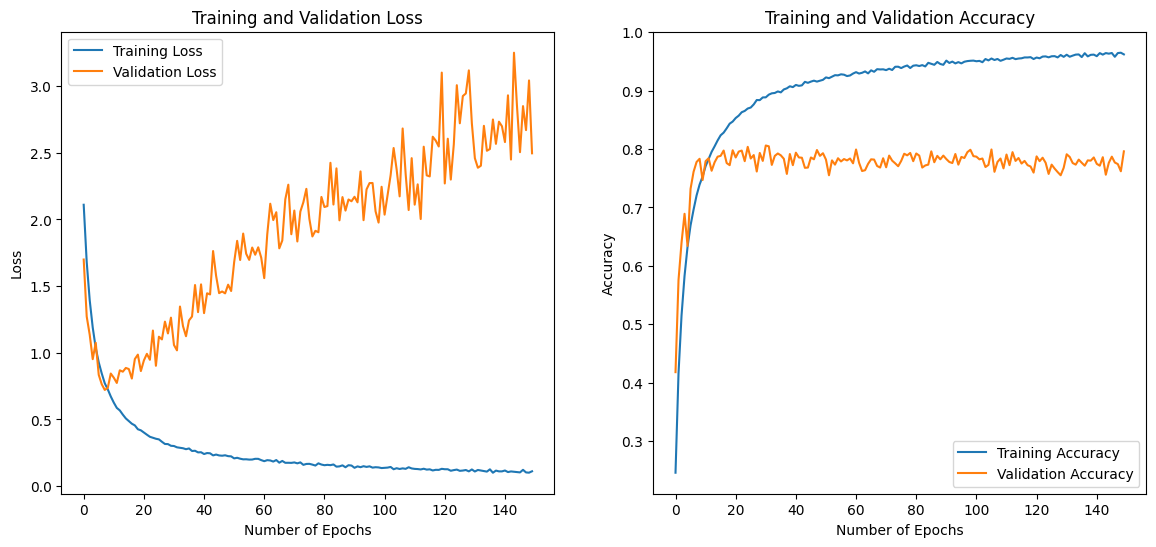

In [64]:
plot_learning_curve(history)

Observations:
- The learning rate might be too slow/no of epochs need to be increased
- Adding augmented images makes the validation predictions more inconsistent and messy
- Hence, adding Augmented Data to our model might not be helpful

### BatchNormalization

In [ ]:
batchNorm_23 = Sequential(name="batchNorm_37", layers = [
    Rescaling(1.0/255, input_shape=(23, 23, 1)), 
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

batchNorm_23.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

batchNorm_23.summary()

Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 23, 23, 32)        320       
                                                                 
 batch_normalization_6 (Batc  (None, 23, 23, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_14 (Conv2D)          (None, 23, 23, 64)        18496     
                                                                 
 batch_normalization_7 (Batc  (None, 23, 23, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                          

In [ ]:
history = batchNorm_23.fit(
    X_train_23, y_train_23_cat, 
    batch_size=32,
    epochs=150,
    validation_data=(X_val_23, y_val_23_cat),
    class_weight=class_weight_dict
)

Epoch 1/150
241/241 [==============================] - 3s 9ms/step - loss: 2.2214 - accuracy: 0.2494 - val_loss: 1.7527 - val_accuracy: 0.4186
Epoch 2/150
241/241 [==============================] - 2s 8ms/step - loss: 1.8314 - accuracy: 0.3704 - val_loss: 1.5948 - val_accuracy: 0.4886
Epoch 3/150
241/241 [==============================] - 2s 8ms/step - loss: 1.5110 - accuracy: 0.4821 - val_loss: 1.1953 - val_accuracy: 0.6191
Epoch 4/150
241/241 [==============================] - 2s 8ms/step - loss: 1.2933 - accuracy: 0.5497 - val_loss: 0.9291 - val_accuracy: 0.6991
Epoch 5/150
241/241 [==============================] - 2s 8ms/step - loss: 1.0993 - accuracy: 0.6103 - val_loss: 0.9165 - val_accuracy: 0.6905
Epoch 6/150
241/241 [==============================] - 2s 8ms/step - loss: 0.9892 - accuracy: 0.6589 - val_loss: 0.7640 - val_accuracy: 0.7618
Epoch 7/150
241/241 [==============================] - 2s 8ms/step - loss: 0.8337 - accuracy: 0.6981 - val_loss: 0.8072 - val_accuracy: 0.7427

In [ ]:
test_loss, test_acc = batchNorm_23.evaluate(X_test_23, y_test_23_cat)
print(f"Test accuracy: {test_acc:.2f}")

69/69 [==============================] - 0s 4ms/step - loss: 0.8234 - accuracy: 0.8945
Test accuracy: 0.89


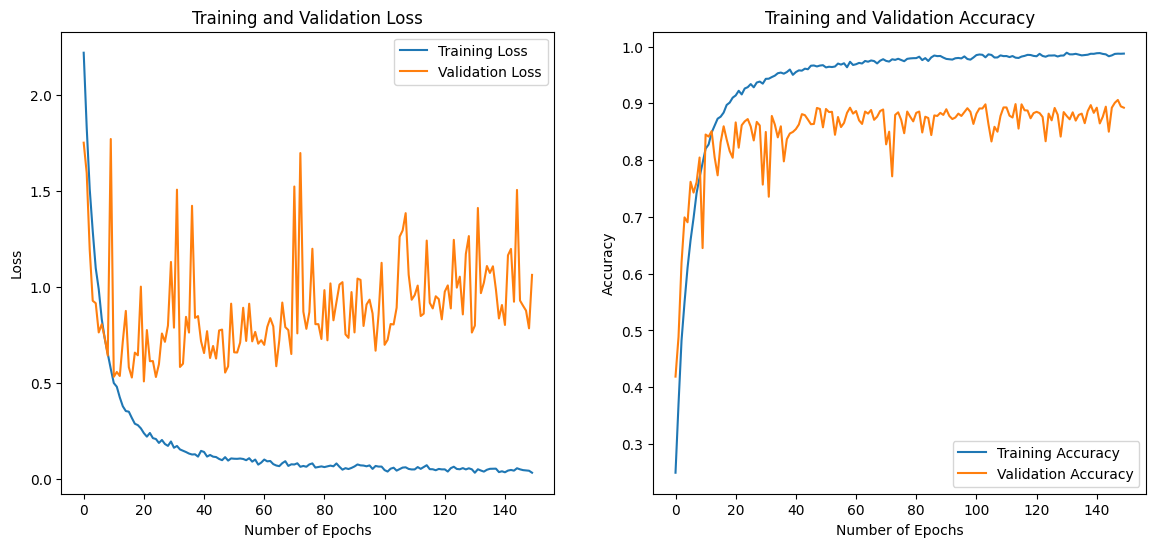

In [35]:
plot_learning_curve(history)

### More Layers

In [46]:
# Define the model
model1_23 = Sequential(name="model1_23", layers = [
    Rescaling(1.0/255, input_shape=(23, 23, 1)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model1_23.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model1_23.summary()

Model: "model1_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_15 (Rescaling)    (None, 23, 23, 1)         0         
                                                                 
 conv2d_50 (Conv2D)          (None, 23, 23, 32)        320       
                                                                 
 batch_normalization_33 (Bat  (None, 23, 23, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_51 (Conv2D)          (None, 23, 23, 32)        9248      
                                                                 
 batch_normalization_34 (Bat  (None, 23, 23, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 11, 11, 32)       0 

In [47]:
history = model1_23.fit(
    X_train_23, y_train_23_cat, 
    batch_size=32,
    epochs=150,
    validation_data=(X_val_23, y_val_23_cat),
    class_weight=class_weight_dict
)

Epoch 1/150
241/241 [==============================] - 2s 7ms/step - loss: 1.9569 - accuracy: 0.3341 - val_loss: 4.2991 - val_accuracy: 0.0909
Epoch 2/150
241/241 [==============================] - 1s 6ms/step - loss: 1.3076 - accuracy: 0.5596 - val_loss: 4.8695 - val_accuracy: 0.1414
Epoch 3/150
241/241 [==============================] - 1s 6ms/step - loss: 0.9750 - accuracy: 0.6742 - val_loss: 1.1523 - val_accuracy: 0.6027
Epoch 4/150
241/241 [==============================] - 1s 6ms/step - loss: 0.7323 - accuracy: 0.7580 - val_loss: 0.7145 - val_accuracy: 0.7650
Epoch 5/150
241/241 [==============================] - 1s 6ms/step - loss: 0.5711 - accuracy: 0.8121 - val_loss: 0.6378 - val_accuracy: 0.7941
Epoch 6/150
241/241 [==============================] - 2s 6ms/step - loss: 0.4340 - accuracy: 0.8558 - val_loss: 0.5811 - val_accuracy: 0.8105
Epoch 7/150
241/241 [==============================] - 2s 6ms/step - loss: 0.3520 - accuracy: 0.8841 - val_loss: 0.6093 - val_accuracy: 0.8150

KeyboardInterrupt: 

In [ ]:
test_loss, test_acc = model1_23.evaluate(X_test_23, y_test_23_cat)
print(f"Test accuracy: {test_acc:.2f}")

69/69 [==============================] - 0s 3ms/step - loss: 0.9280 - accuracy: 0.8864
Test accuracy: 0.89


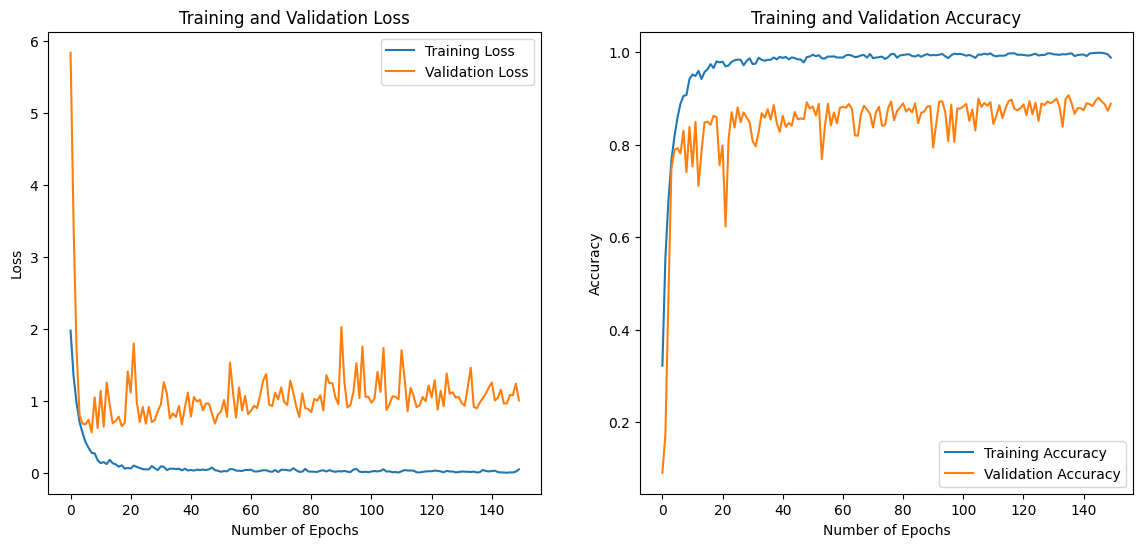

In [ ]:
plot_learning_curve(history)

### Reduce Overfitting

In [ ]:
model2_23 = Sequential(name="model2_23", layers = [
    Rescaling(1.0/255, input_shape=(23, 23, 1)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model2_23.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model2_23.summary()

Model: "model2_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 23, 23, 1)         0         
                                                                 
 conv2d_46 (Conv2D)          (None, 23, 23, 32)        320       
                                                                 
 conv2d_47 (Conv2D)          (None, 23, 23, 32)        9248      
                                                                 
 batch_normalization_30 (Bat  (None, 23, 23, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 11, 11, 32)       0         
 g2D)                                                            
                                                                 
 dropout_41 (Dropout)        (None, 11, 11, 32)        0 

In [ ]:
history = model2_23.fit(
    X_train_23, y_train_23_cat, 
    batch_size=32,
    epochs=150,
    validation_data=(X_val_23, y_val_23_cat),
    class_weight=class_weight_dict
)

Epoch 1/150
241/241 [==============================] - 3s 7ms/step - loss: 2.8510 - accuracy: 0.1799 - val_loss: 14.2506 - val_accuracy: 0.0909
Epoch 2/150
241/241 [==============================] - 2s 6ms/step - loss: 2.3235 - accuracy: 0.2985 - val_loss: 9.5914 - val_accuracy: 0.1373
Epoch 3/150
241/241 [==============================] - 2s 6ms/step - loss: 2.1066 - accuracy: 0.3750 - val_loss: 1.8748 - val_accuracy: 0.4700
Epoch 4/150
241/241 [==============================] - 2s 6ms/step - loss: 1.9253 - accuracy: 0.4457 - val_loss: 1.6622 - val_accuracy: 0.5455
Epoch 5/150
241/241 [==============================] - 2s 7ms/step - loss: 1.7592 - accuracy: 0.4853 - val_loss: 1.9163 - val_accuracy: 0.4836
Epoch 6/150
241/241 [==============================] - 2s 6ms/step - loss: 1.6170 - accuracy: 0.5327 - val_loss: 2.0446 - val_accuracy: 0.4682
Epoch 7/150
241/241 [==============================] - 2s 7ms/step - loss: 1.4776 - accuracy: 0.5808 - val_loss: 1.4129 - val_accuracy: 0.623

In [ ]:
test_loss, test_acc = model2_37.evaluate(X_test_23, y_test_23_cat)
print(f"Test accuracy: {test_acc:.2f}")

69/69 [==============================] - 0s 2ms/step - loss: 0.3979 - accuracy: 0.9255
Test accuracy: 0.93


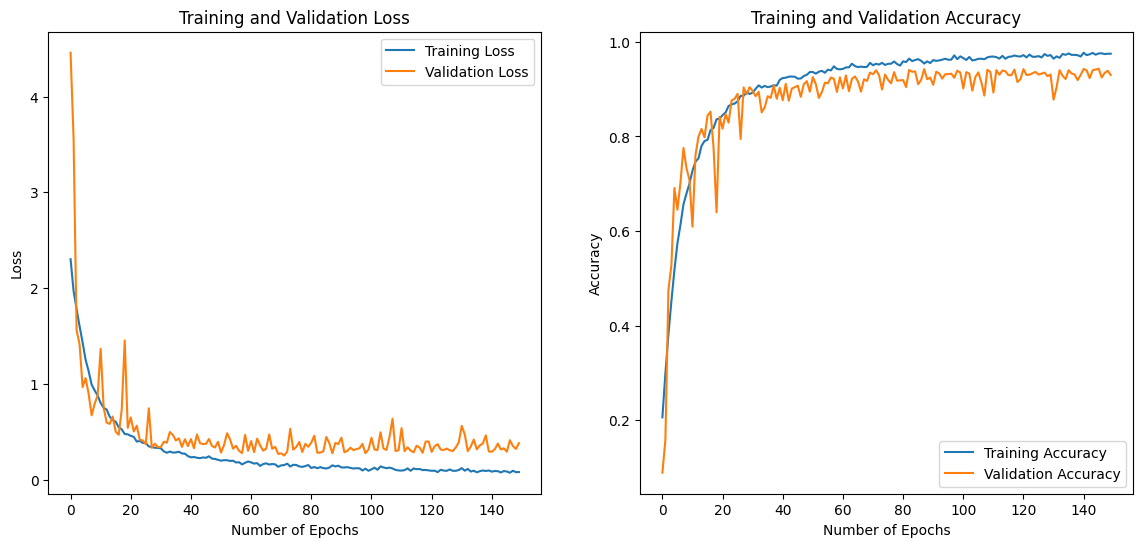

In [84]:
plot_learning_curve(history)

# 101x101 Model

## Model training

In [15]:
# One-hot encode the labels
num_classes = len(class_names)
y_train_101_cat = to_categorical(y_train_101, num_classes)
y_val_101_cat = to_categorical(y_val_101, num_classes)
y_test_101_cat = to_categorical(y_test_101, num_classes)

In [11]:
baseline_101 = Sequential(name="baseline_101", layers = [
    Rescaling(1.0/255, input_shape=(101, 101, 1)), # Normalize data
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(101, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

baseline_101.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

baseline_101.summary()

Model: "baseline_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 101, 101, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 99, 99, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 256)      

In [12]:
history = baseline_101.fit(
    X_train_101, y_train_101_cat,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_101, y_val_101_cat),
)

Epoch 1/100
241/241 [==============================] - 13s 25ms/step - loss: 2.2106 - accuracy: 0.2120 - val_loss: 2.0892 - val_accuracy: 0.2386
Epoch 2/100
241/241 [==============================] - 5s 22ms/step - loss: 1.8717 - accuracy: 0.3526 - val_loss: 1.5828 - val_accuracy: 0.4709
Epoch 3/100
241/241 [==============================] - 5s 22ms/step - loss: 1.6040 - accuracy: 0.4391 - val_loss: 1.4196 - val_accuracy: 0.5205
Epoch 4/100
241/241 [==============================] - 5s 22ms/step - loss: 1.3738 - accuracy: 0.5203 - val_loss: 1.1300 - val_accuracy: 0.6377
Epoch 5/100
241/241 [==============================] - 5s 22ms/step - loss: 1.2288 - accuracy: 0.5714 - val_loss: 0.9797 - val_accuracy: 0.6873
Epoch 6/100
241/241 [==============================] - 5s 22ms/step - loss: 1.1038 - accuracy: 0.6113 - val_loss: 1.1032 - val_accuracy: 0.6386
Epoch 7/100
241/241 [==============================] - 5s 22ms/step - loss: 0.9873 - accuracy: 0.6452 - val_loss: 0.8401 - val_accuracy

In [13]:
test_loss, test_acc = baseline_101.evaluate(X_test_101, y_test_101_cat)
print(f"Test accuracy: {test_acc:.2f}")

69/69 [==============================] - 1s 7ms/step - loss: 1.0380 - accuracy: 0.8568
Test accuracy: 0.86


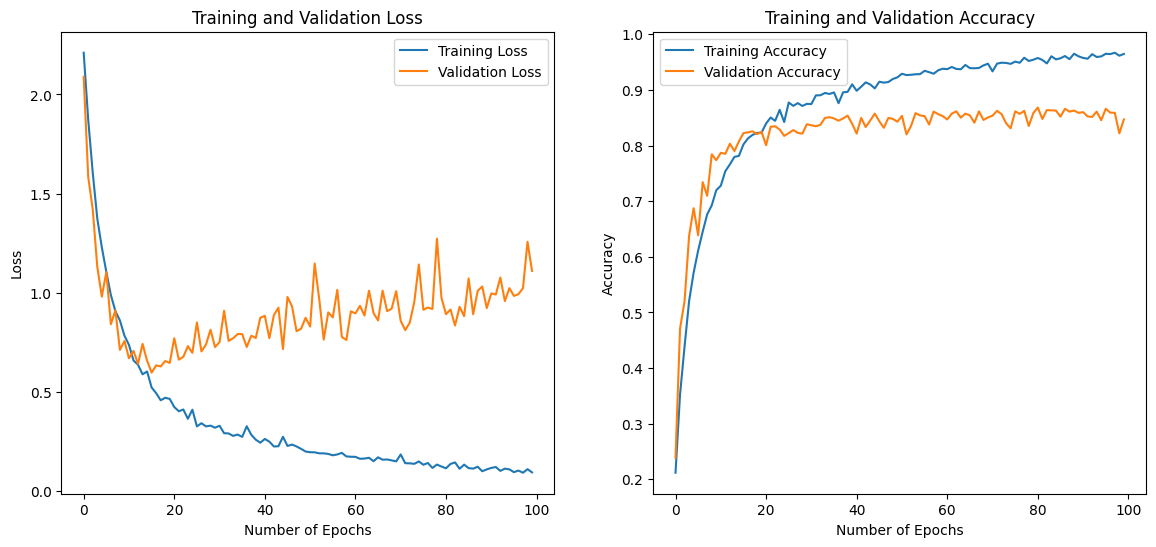

In [17]:
plot_learning_curve(history)

## Model Improvement

In [ ]:
from keras.regularizers import l2

model1_101 = Sequential(name="model1_101", layers = [
    Rescaling(1.0/255, input_shape=(101, 101, 1)), # Normalize data
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model1_101.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model1_101.summary()

In [ ]:
history = model1_101.fit(
    X_train_101, y_train_101_cat, 
    batch_size=32,
    epochs=100,
    validation_data=(X_val_101, y_val_101_cat),
    class_weight=class_weight_dict
)

In [ ]:
test_loss, test_acc = model1_101.evaluate(X_test_101, y_test_101_cat)
print(f"Test accuracy: {test_acc:.2f}")

In [ ]:
plot_learning_curve(history)

In [65]:
from keras.regularizers import l2

model2_101 = Sequential(name="model1_101", layers = [
    Rescaling(1.0/255, input_shape=(101, 101, 1)), # Normalize data
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model2_101.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model2_101.summary()

Model: "model1_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_17 (Rescaling)    (None, 101, 101, 1)       0         
                                                                 
 conv2d_57 (Conv2D)          (None, 101, 101, 64)      640       
                                                                 
 batch_normalization_37 (Bat  (None, 101, 101, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_58 (Conv2D)          (None, 101, 101, 64)      36928     
                                                                 
 batch_normalization_38 (Bat  (None, 101, 101, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 50, 50, 64)       0

In [66]:
history = model2_101.fit(
    X_train_101, y_train_101_cat, 
    batch_size=32,
    epochs=50,
    validation_data=(X_val_101, y_val_101_cat),
    class_weight=class_weight_dict
) 

Epoch 1/50
  1/241 [..............................] - ETA: 2:44 - loss: 6.6295 - accuracy: 0.0625

KeyboardInterrupt: 

In [ ]:
test_loss, test_acc = model2_101.evaluate(X_test_101, y_test_101_cat)
print(f"Test accuracy: {test_acc:.2f}")

69/69 [==============================] - 1s 10ms/step - loss: 0.4492 - accuracy: 0.9118
Test accuracy: 0.91


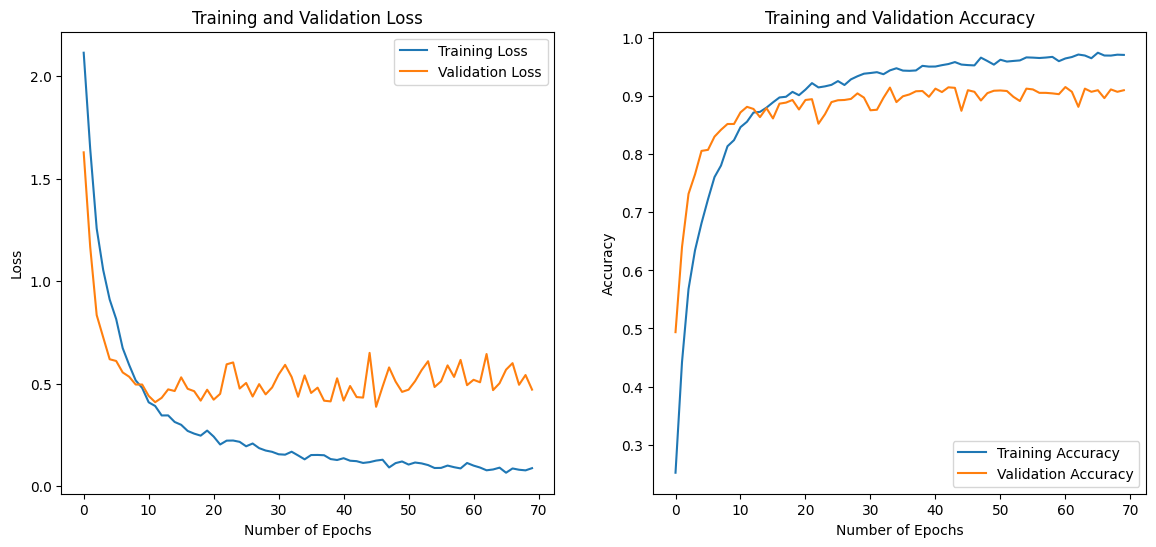

In [40]:
plot_learning_curve(history)